##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用变分推断拟合广义线性混合效应模型

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/probability/examples/Linear_Mixed_Effects_Model_Variational_Inference"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>   </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/Linear_Mixed_Effects_Model_Variational_Inference.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a> </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/Linear_Mixed_Effects_Model_Variational_Inference.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/probability/examples/Linear_Mixed_Effects_Model_Variational_Inference.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

In [ ]:
#@title Install { display-mode: "form" }
TF_Installation = 'System' #@param ['TF Nightly', 'TF Stable', 'System']

if TF_Installation == 'TF Nightly':
  !pip install -q --upgrade tf-nightly
  print('Installation of `tf-nightly` complete.')
elif TF_Installation == 'TF Stable':
  !pip install -q --upgrade tensorflow
  print('Installation of `tensorflow` complete.')
elif TF_Installation == 'System':
  pass
else:
  raise ValueError('Selection Error: Please select a valid '
                   'installation option.')

In [ ]:
#@title Install { display-mode: "form" }
TFP_Installation = "System" #@param ["Nightly", "Stable", "System"]

if TFP_Installation == "Nightly":
  !pip install -q tfp-nightly
  print("Installation of `tfp-nightly` complete.")
elif TFP_Installation == "Stable":
  !pip install -q --upgrade tensorflow-probability
  print("Installation of `tensorflow-probability` complete.")
elif TFP_Installation == "System":
  pass
else:
  raise ValueError("Selection Error: Please select a valid "
                   "installation option.")

## 摘要


在此 Colab 中，我们将演示如何使用 TensorFlow Probability 中的变分推断来拟合广义线性混合效应模型。


## 模型系列

[广义线性混合效应模型](https://en.wikipedia.org/wiki/Generalized_linear_mixed_model) (GLMM) 与[广义线性模型](https://en.wikipedia.org/wiki/Generalized_linear_model) (GLM) 类似，不同之处在于，它们在预测的线性响应中加入了样本特定的噪声。这在一定程度上很有用，因为它允许罕见的特征与更常见的特征共享信息。


作为一个生成式过程，广义线性混合效应模型 (GLMM) 的表征为：

$$ \begin{align} \text{for } &amp; r = 1\ldots R:  \hspace{2.45cm}\text{# 对于每个随机效应组}\ &amp;\begin{aligned} \text{for } &amp;c = 1\ldots |C_r|:  \hspace{1.3cm}\text{# 对于 $r$ 组的每个类别（“级别”）\ &amp;\begin{aligned} \beta_{rc} &amp;\sim \text{MultivariateNormal}(\text{loc}=0_{D_r}, \text{scale}=\Sigma_r^{1/2}) \end{aligned} \end{aligned}\\ \text{for } &amp; i = 1 \ldots N:  \hspace{2.45cm}\text{# 对于每个样本}\ &amp;\begin{aligned} &amp;\eta_i = \underbrace{\vphantom{\sum_{r=1}^R}x_i^\top\omega}<em data-md-type="emphasis">\text{固定效应} + \underbrace{\sum</em>{r=1}^R z_{r,i}^\top \beta_{r,C_r(i) }}<em data-md-type="emphasis">\text{随机效应} \ &amp;Y_i|x_i,\omega,{z</em>{r,i} , \beta_r}_{r=1}^R \sim \text{Distribution}(\text{mean}= g^{-1}(\eta_i)) \end{aligned} \end{align} $$

其中：

$$ \begin{align} R &amp;= \text{随机效应组的数量}\ |C_r| &amp;= \text{$r$ 组的类别数量}\ N &amp;= \text{训练样本的数量}\ x_i,\omega &amp;\in \mathbb{R}^{D_0}\ D_0 &amp;= \text{固定效应的数量}\ C_r(i) &amp;= \text{第 $i$ 个样本的类别（$r$ 组下）}\ z_{r,i} &amp;\in \mathbb{R}^{D_r}\ D_r &amp;= \text{与 $r$ 组相关的随机效应数量}\ \Sigma_{r} &amp;\in {S\in\mathbb{R}^{D_r \times D_r} : S \succ 0 }\ \eta_i\mapsto g^{-1}(\eta_i) &amp;= \mu_i, \text{反联系函数}\ \text{Distribution} &amp;=\text{某个只能通过其均值来参数化的分布} \end{align} $$

换句话说，这意味着每个组的每个类别都与来自多元正态分布的样本 $\beta_{rc}$ 相关。尽管 $\beta_{rc}$ 抽样始终是独立的，但它们只对 $r$ 组有相同的分布：请注意，每个 $r\in{1,\ldots,R}$ 有且只有一个 $\Sigma_r$。

当以仿射的方式与样本的组的特征 ($z_{r,i}$) 组合时，结果是第 $i$ 个预测线性响应的样本特定噪声（否则为 $x_i^\top\omega$）。

当我们估计 ${\Sigma_r:r\in{1,\ldots,R}}$ 时，我们本质上是在估计随机效应组携带的噪声量，否则这些噪声会淹没 $x_i^\top\omega$ 中存在的信号。

$\text{Distribution}$ 和[反向链接函数](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function) $g^{-1}$ 有多种选择。常见的选择有：

- $Y_i\sim\text{Normal}(\text{mean}=\eta_i, \text{scale}=\sigma)$，
- $Y_i\sim\text{Binomial}(\text{mean}=n_i \cdot \text{sigmoid}(\eta_i), \text{total_count}=n_i)$，以及
- $Y_i\sim\text{Poisson}(\text{mean}=\exp(\eta_i))$。

有关更多可能性，请参阅 [`tfp.glm`](https://github.com/tensorflow/probability/tree/main/tensorflow_probability/python/glm) 模块。

## 变分推断

不幸的是，寻找参数 $\beta,{\Sigma_r}_r^R$ 的最大似然估计需要一个非分析积分。为了规避这个问题，我们改用以下方式：

1. 定义一个参数化的分布系列（“代理密度”），在附录中表示为 $q_{\lambda}$。
2. 找到参数 $\lambda$，使 $q_{\lambda}$ 接近我们的真实目标密度。

分布系列将是适当维度的独立高斯，而 “接近我们的目标密度”的意思是“最小化 [K-L 散度](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)”。例如，请查看[“Variational Inference: A Review for Statisticians”第 2.2 节](https://arxiv.org/abs/1601.00670)中写得很好的推导与动机。特别是，它表明最小化 K-L 散度等同于最小化负证据下界 (ELBO)。

## 小型问题

[Gelman 等人（2007 年）提出的“氡数据集”](http://www.stat.columbia.edu/~gelman/arm/)有时会被用来演示回归方法。（例如，这篇密切相关的 [PyMC3 博文](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/)。）氡数据集包含美国各地的室内氡测量值。[氡](https://en.wikipedia.org/wiki/Radon)是一种天然存在的放射性气体，高浓度时具有[毒性](http://www.radon.com/radon_facts/)。

对于我们的演示，假设我们想要验证以下假设：包含地下室的住宅中氡的含量较高。我们还怀疑氡的浓度与土壤类型有关，即地理位置很重要。

为了将其描述为一个 ML 问题，我们将尝试根据获取读数的楼层的线性函数来预测对数氡含量。我们还将使用“县”作为随机效应，以此方式考虑由于地理位置引起的差异。换句话说，我们将使用[广义线性混合效应模型](https://en.wikipedia.org/wiki/Generalized_linear_mixed_model)。

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
from six.moves import urllib

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_context('notebook')
import tensorflow_datasets as tfds

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

我们还将快速检查 GPU 的可用性：

In [ ]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print("We'll just use the CPU for this run.")
else:
  print('Huzzah! Found GPU: {}'.format(tf.test.gpu_device_name()))

We'll just use the CPU for this run.


### 获取数据集：

我们从 TensorFlow Datasets 加载数据集并进行一些简单的预处理。

In [ ]:
def load_and_preprocess_radon_dataset(state='MN'):
  """Load the Radon dataset from TensorFlow Datasets and preprocess it.
  
  Following the examples in "Bayesian Data Analysis" (Gelman, 2007), we filter
  to Minnesota data and preprocess to obtain the following features:
  - `county`: Name of county in which the measurement was taken.
  - `floor`: Floor of house (0 for basement, 1 for first floor) on which the
    measurement was taken.

  The target variable is `log_radon`, the log of the Radon measurement in the
  house.
  """
  ds = tfds.load('radon', split='train')
  radon_data = tfds.as_dataframe(ds)
  radon_data.rename(lambda s: s[9:] if s.startswith('feat') else s, axis=1, inplace=True)
  df = radon_data[radon_data.state==state.encode()].copy()

  df['radon'] = df.activity.apply(lambda x: x if x > 0. else 0.1)
  # Make county names look nice. 
  df['county'] = df.county.apply(lambda s: s.decode()).str.strip().str.title()
  # Remap categories to start from 0 and end at max(category).
  df['county'] = df.county.astype(pd.api.types.CategoricalDtype())
  df['county_code'] = df.county.cat.codes
  # Radon levels are all positive, but log levels are unconstrained
  df['log_radon'] = df['radon'].apply(np.log)

  # Drop columns we won't use and tidy the index 
  columns_to_keep = ['log_radon', 'floor', 'county', 'county_code']
  df = df[columns_to_keep].reset_index(drop=True)
 
  return df

df = load_and_preprocess_radon_dataset()
df.head()

log_radon  floor  county  county_code
0   0.788457      1  Aitkin            0
1   0.788457      0  Aitkin            0
2   1.064711      0  Aitkin            0
3   0.000000      0  Aitkin            0
4   1.131402      0   Anoka            1

### 专门化 GLMM 系列

在本部分中，我们将 GLMM 系列专门用于预测氡含量的任务。为此，我们首先考虑 GLMM 的固定效应特例：$$ \mathbb{E}[\log(\text{radon}_j)] = c + \text{floor_effect}_j $$

该模型假设观测值 $j$ 中的对数氡（按预期）由获得第 $j$ 个读数的所在楼层，外加某个常数截距所决定。我们可以使用伪代码编写以下内容：

```
def estimate_log_radon(floor):
    return intercept + floor_effect[floor]
```

每个楼层都有一个学习的权重和一个通用的 `intercept` 项。 从 0 楼和 1 楼的氡测量结果来看，这可能是一个好的开始：

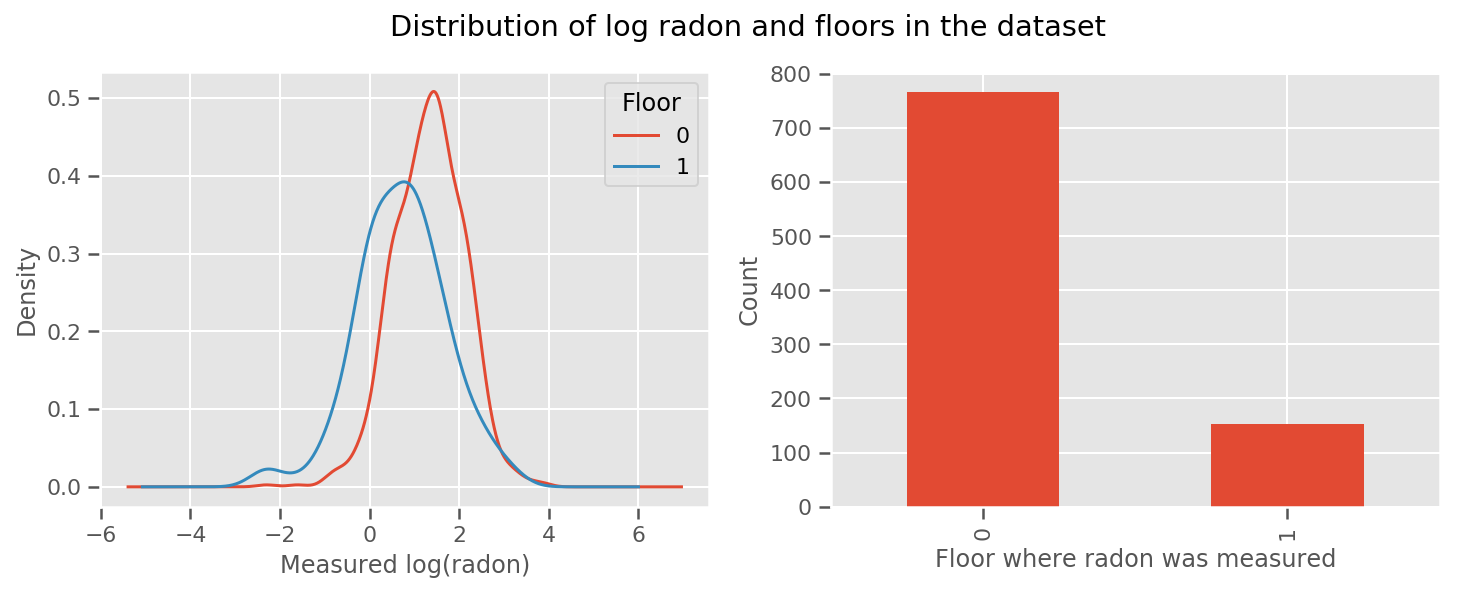

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
df.groupby('floor')['log_radon'].plot(kind='density', ax=ax1);
ax1.set_xlabel('Measured log(radon)')
ax1.legend(title='Floor')

df['floor'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_xlabel('Floor where radon was measured')
ax2.set_ylabel('Count')
fig.suptitle("Distribution of log radon and floors in the dataset");

为了使模型更复杂一些，包括一些关于地理位置的内容可能会更好：氡是铀的衰变链的一部分，而铀可能存在于地下，因此地理位置似乎是关键。

$$ \mathbb{E}[\log(\text{radon}_j)] = c + \text{floor_effect}_j + \text{county_effect}_j $$

同样，在伪代码中，我们有

$$ \mathbb{E}[\log(\text{radon}_j)] = c + \text{floor_effect}_j + \text{county_effect}_j $$

除具有特定于县的权重外，其余与之前相同。

如果给定足够大的训练集，这就是一个合理的模型。但是，根据我们从明尼苏达州获得的数据，我们看到有大量的县的测量数量很少。例如，85 个县中有 39 个县的观测值少于 5 个。

这就促使我们在所有观测值之间共享统计强度，随着每个县的观测值数量的增加，这种方式会收敛到上述模型。

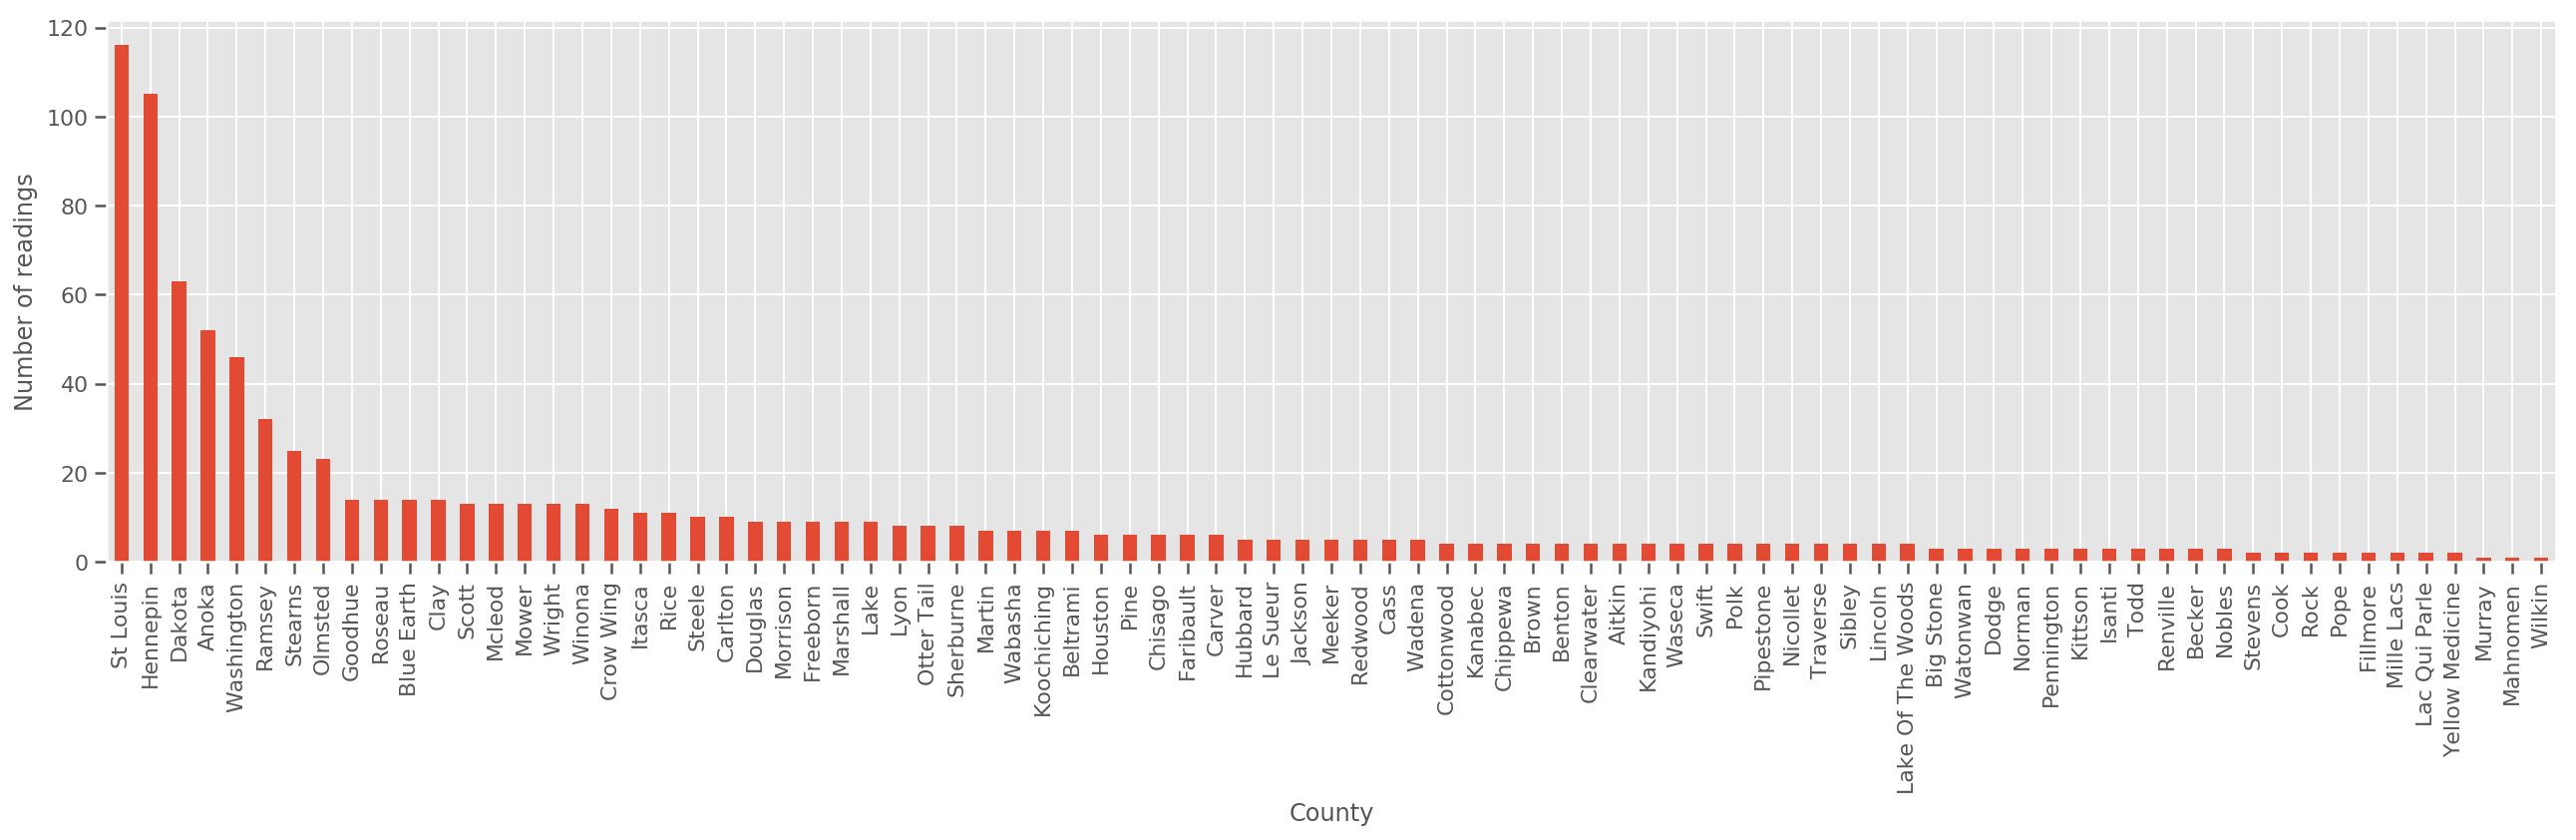

In [ ]:
fig, ax = plt.subplots(figsize=(22, 5));
county_freq = df['county'].value_counts()
county_freq.plot(kind='bar', ax=ax)
ax.set_xlabel('County')
ax.set_ylabel('Number of readings');

如果我们拟合该模型，`county_effect` 向量最终可能会记住只有几个训练样本的县的结果，可能会过拟合并导致泛化效果不好。

GLMM 提供了上述两个 GLM 的适当中间值。我们可以考虑拟合

$$ \log(\text{radon}_j) \sim c + \text{floor_effect}_j + \mathcal{N}(\text{county_effect}_j, \text{county_scale}) $$

该模型与第一个模型相同，但我们已将似然固定为正态分布，并将通过（单个）变量 `county_scale` 共享所有县的方差。可用伪代码表示为：

$$ \log(\text{radon}_j) \sim c + \text{floor_effect}_j + \mathcal{N}(\text{county_effect}_j, \text{county_scale}) $$

我们将使用观测数据推断出 `county_scale`、`county_mean` 和 `random_effect` 上的联合分布。我们可以通过全局 `county_scale` 在各个县之间共享统计强度：具有许多观测值的县会为具有较少观测值的县的方差提供了帮助。此外，随着我们收集更多的数据，该模型将收敛到没有池化尺度变量的模型。即使使用此数据集，我们使用任一模型也会得出有关具有最多观测值的县的类似结论。

## 实验

现在，我们将尝试使用 TensorFlow 中的变分推断来拟合上述 GLMM。首先，我们将数据拆分为特征和标签。

In [ ]:
features = df[['county_code', 'floor']].astype(int)
labels = df[['log_radon']].astype(np.float32).values.flatten()

### 指定模型

In [ ]:
def make_joint_distribution_coroutine(floor, county, n_counties, n_floors):

  def model():
    county_scale = yield tfd.HalfNormal(scale=1., name='scale_prior')
    intercept = yield tfd.Normal(loc=0., scale=1., name='intercept')
    floor_weight = yield tfd.Normal(loc=0., scale=1., name='floor_weight')
    county_prior = yield tfd.Normal(loc=tf.zeros(n_counties),
                                    scale=county_scale,
                                    name='county_prior')
    random_effect = tf.gather(county_prior, county, axis=-1)

    fixed_effect = intercept + floor_weight * floor
    linear_response = fixed_effect + random_effect
    yield tfd.Normal(loc=linear_response, scale=1., name='likelihood')
  return tfd.JointDistributionCoroutineAutoBatched(model)

joint = make_joint_distribution_coroutine(
    features.floor.values, features.county_code.values, df.county.nunique(),
    df.floor.nunique())

# Define a closure over the joint distribution 
# to condition on the observed labels.
def target_log_prob_fn(*args):
  return joint.log_prob(*args, likelihood=labels)

### 指定代理后验

现在，我们组建一个代理系列 $q_{\lambda}$，其中参数 $\lambda$ 可训练。在本例中，我们的系列是独立的多元正态分布，每个参数一个分布，并且 $\lambda = {(\mu_j, \sigma_j)}$，其中 $j$ 对四个参数进行索引。

我们用来拟合代理系列的方法使用 `tf.Variables`。我们还使用 `tfp.util.TransformedVariable` 和 `Softplus` 来将（可训练）尺度参数约束为正值。此外，我们将 `Softplus` 应用于整个 `scale_prior`，这是一个正参数。

我们使用一些抖动来初始化这些可训练变量，以帮助优化。

In [ ]:
# Initialize locations and scales randomly with `tf.Variable`s and 
# `tfp.util.TransformedVariable`s.
_init_loc = lambda shape=(): tf.Variable(
    tf.random.uniform(shape, minval=-2., maxval=2.))
_init_scale = lambda shape=(): tfp.util.TransformedVariable(
    initial_value=tf.random.uniform(shape, minval=0.01, maxval=1.),
    bijector=tfb.Softplus())
n_counties = df.county.nunique()

surrogate_posterior = tfd.JointDistributionSequentialAutoBatched([
  tfb.Softplus()(tfd.Normal(_init_loc(), _init_scale())),           # scale_prior
  tfd.Normal(_init_loc(), _init_scale()),                           # intercept
  tfd.Normal(_init_loc(), _init_scale()),                           # floor_weight
  tfd.Normal(_init_loc([n_counties]), _init_scale([n_counties]))])  # county_prior

请注意，此单元可以替换为 [`tfp.experimental.vi.build_factored_surrogate_posterior`](https://tensorflow.google.cn/probability/api_docs/python/tfp/experimental/vi/build_factored_surrogate_posterior?version=nightly)，如下所示：

```python
surrogate_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(
  event_shape=joint.event_shape_tensor()[:-1],
  constraining_bijectors=[tfb.Softplus(), None, None, None])
```

### 结果

回想一下，我们的目标是定义一个易处理的参数化分布系列，然后选择参数，使我们拥有一个接近目标分布的易处理的分布。

我们已在上面构建了代理分布，并且可以使用 [`tfp.vi.fit_surrogate_posterior`](https://tensorflow.google.cn/probability/api_docs/python/tfp/vi/fit_surrogate_posterior)，它接受一个优化器和给定数量的步骤，来寻找最小化负 ELBO（对应于最小化代理和目标分布之间的 K-L 散度）的代理模型参数。

返回值是每个步骤的负 ELBO，`surrogate_posterior` 中的分布将使用优化器找到的参数进行更新。

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=1e-2)

losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn, 
    surrogate_posterior,
    optimizer=optimizer,
    num_steps=3000, 
    seed=42,
    sample_size=2)

(scale_prior_, 
 intercept_, 
 floor_weight_, 
 county_weights_), _ = surrogate_posterior.sample_distributions()

In [ ]:
print('        intercept (mean): ', intercept_.mean())
print('     floor_weight (mean): ', floor_weight_.mean())
print(' scale_prior (approx. mean): ', tf.reduce_mean(scale_prior_.sample(10000)))

        intercept (mean):  tf.Tensor(1.4352839, shape=(), dtype=float32)
     floor_weight (mean):  tf.Tensor(-0.6701997, shape=(), dtype=float32)
 scale_prior (approx. mean):  tf.Tensor(0.28682157, shape=(), dtype=float32)


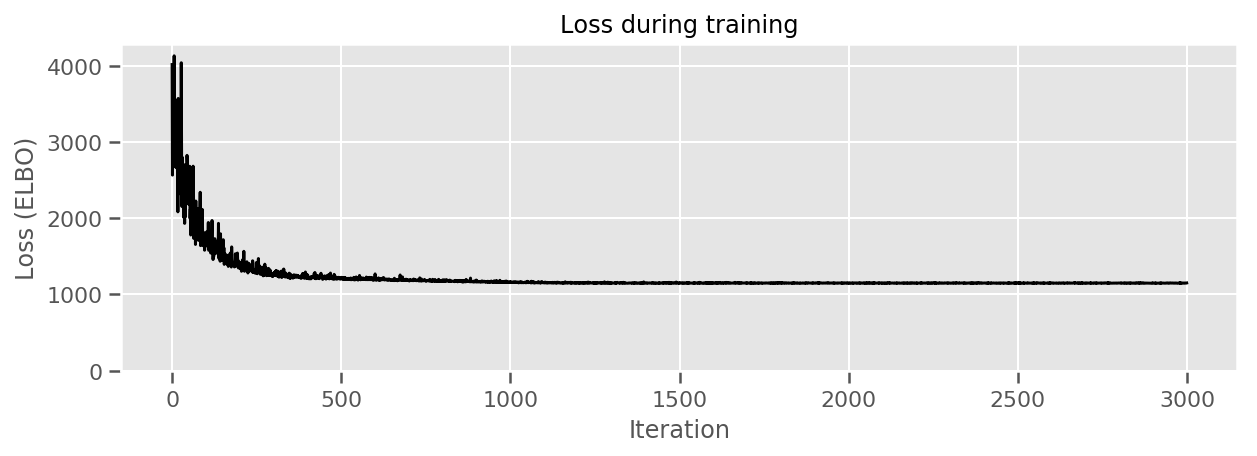

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(losses, 'k-')
ax.set(xlabel="Iteration",
       ylabel="Loss (ELBO)",
       title="Loss during training",
       ylim=0);

我们可以绘制估计的平均县效应，以及该均值的不确定度。我们按照观测值的数量进行排序，左侧数值最大。请注意，有许多观测值的县的不确定度较小，但只有一两个观测值的县的不确定度较大。

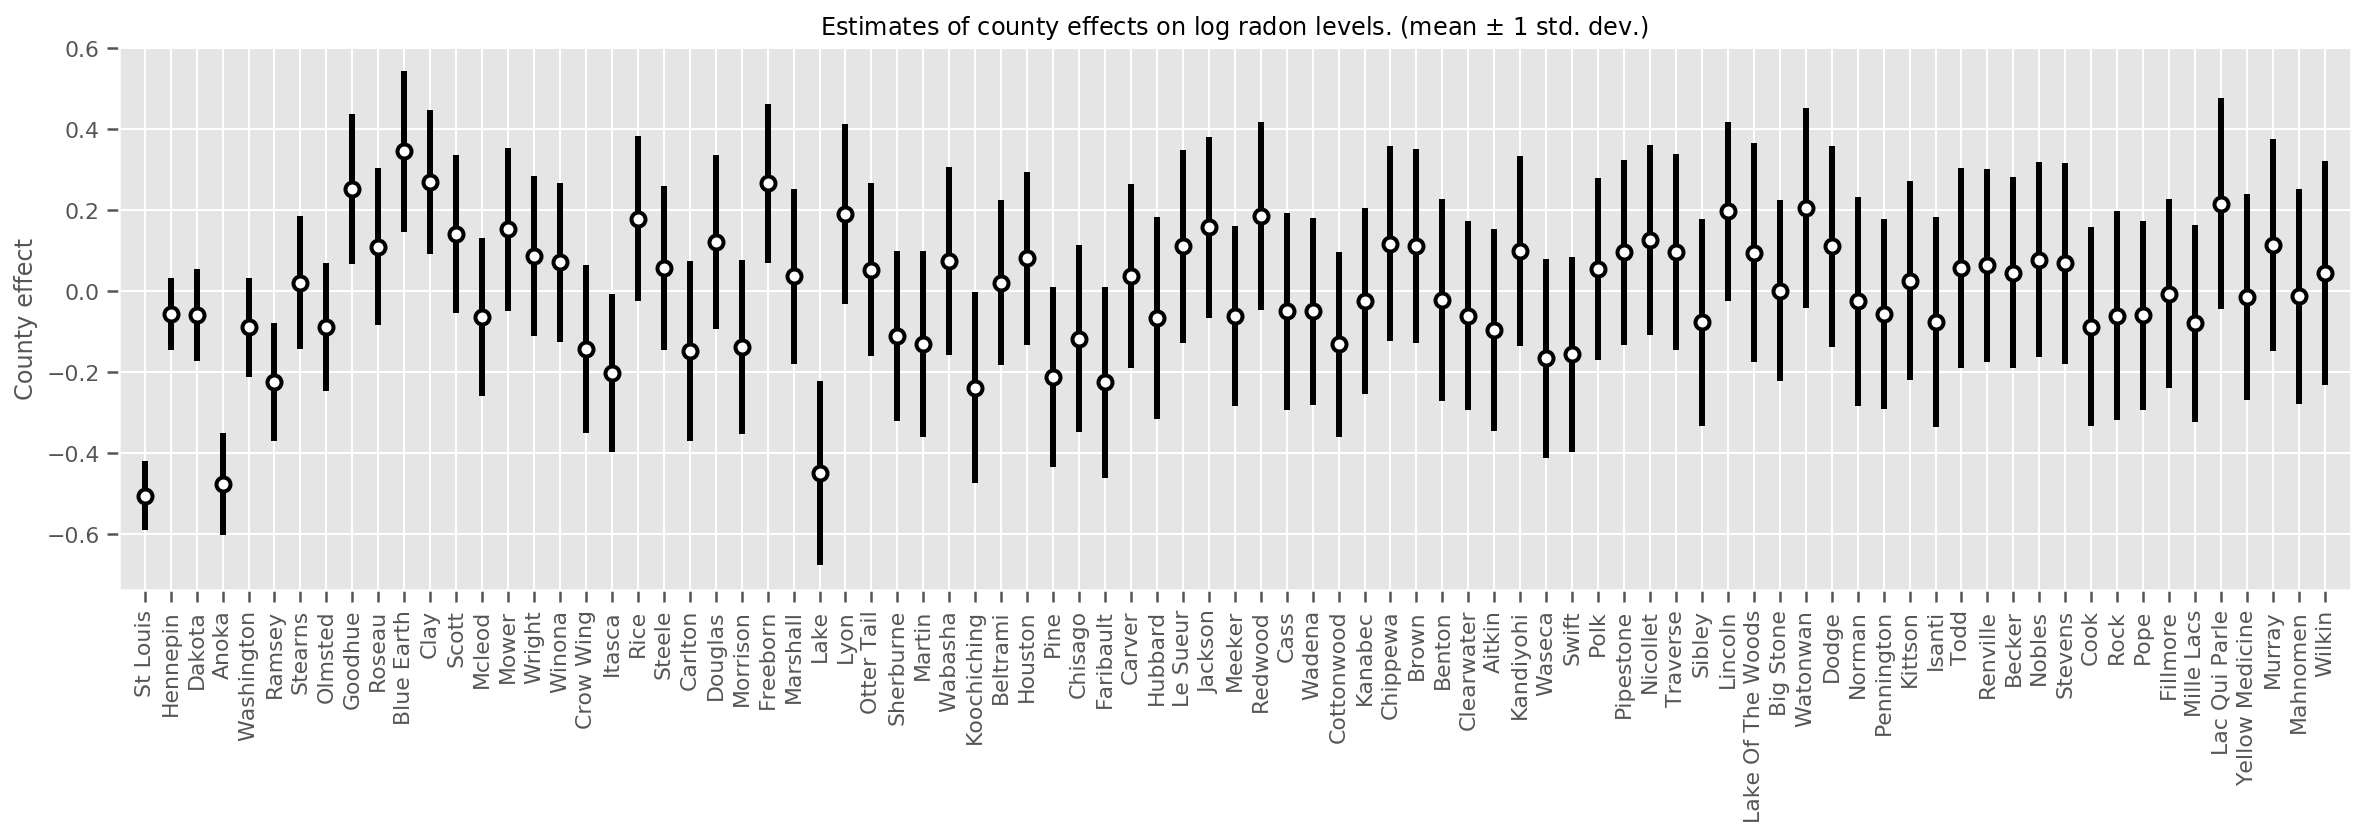

In [ ]:
county_counts = (df.groupby(by=['county', 'county_code'], observed=True)
                   .agg('size')
                   .sort_values(ascending=False)
                   .reset_index(name='count'))

means = county_weights_.mean()
stds = county_weights_.stddev()

fig, ax = plt.subplots(figsize=(20, 5))

for idx, row in county_counts.iterrows():
  mid = means[row.county_code]
  std = stds[row.county_code]
  ax.vlines(idx, mid - std, mid + std, linewidth=3)
  ax.plot(idx, means[row.county_code], 'ko', mfc='w', mew=2, ms=7)

ax.set(
    xticks=np.arange(len(county_counts)),
    xlim=(-1, len(county_counts)),
    ylabel="County effect",
    title=r"Estimates of county effects on log radon levels. (mean $\pm$ 1 std. dev.)",
)
ax.set_xticklabels(county_counts.county, rotation=90);

实际上，我们可以通过绘制观测值的对数与估计标准差的对比图来更直观地看到这一点，并且可以看到两者的关系近似呈线性关系。

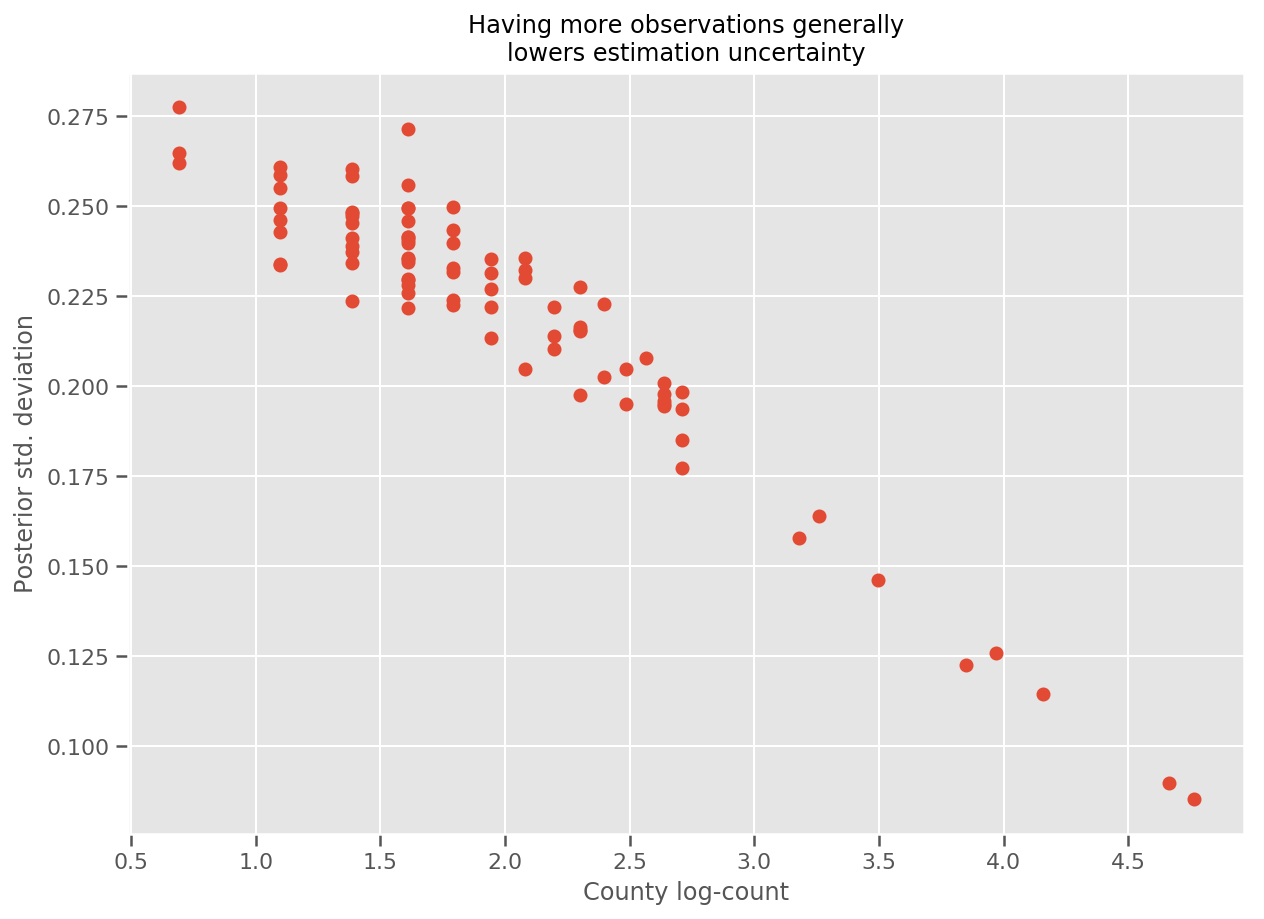

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(np.log1p(county_counts['count']), stds.numpy()[county_counts.county_code], 'o')
ax.set(
    ylabel='Posterior std. deviation',
    xlabel='County log-count',
    title='Having more observations generally\nlowers estimation uncertainty'
);

## 与 R 中的 `lme4` 比较

In [ ]:
%%shell
exit  # Trick to make this block not execute.

radon = read.csv('srrs2.dat', header = TRUE)
radon = radon[radon$state=='MN',]
radon$radon = ifelse(radon$activity==0., 0.1, radon$activity)
radon$log_radon = log(radon$radon)

# install.packages('lme4')
library(lme4)
fit <- lmer(log_radon ~ 1 + floor + (1 | county), data=radon)
fit

# Linear mixed model fit by REML ['lmerMod']
# Formula: log_radon ~ 1 + floor + (1 | county)
#    Data: radon
# REML criterion at convergence: 2171.305
# Random effects:
#  Groups   Name        Std.Dev.
#  county   (Intercept) 0.3282
#  Residual             0.7556
# Number of obs: 919, groups:  county, 85
# Fixed Effects:
# (Intercept)        floor
#       1.462       -0.693

下表对结果进行了汇总。

In [ ]:
print(pd.DataFrame(data=dict(intercept=[1.462, tf.reduce_mean(intercept_.mean()).numpy()],
                             floor=[-0.693, tf.reduce_mean(floor_weight_.mean()).numpy()],
                             scale=[0.3282, tf.reduce_mean(scale_prior_.sample(10000)).numpy()]),
                   index=['lme4', 'vi']))

      intercept   floor     scale
lme4   1.462000 -0.6930  0.328200
vi     1.435284 -0.6702  0.287251


此表显示 VI 结果在 `lme4` 的 ~10% 范围内。这有点令人惊讶，因为：

- `lme4` 基于[拉普拉斯方法](https://www.jstatsoft.org/article/view/v067i01/)（而非 VI），
- 在此 Colab 中，我们并未真正进行收敛，
- 几乎没有调节超参数，
- 未对数据进行正则化或预处理（例如，中心特征等）。

## 结论

在此 Colab 中，我们描述了广义线性混合效应模型，并展示了如何使用 TensorFlow Probability 中的变分推断对其进行拟合。虽然小型问题只有几百个训练样本，但此处使用的技术与大规模所需的技术完全相同。